## Import and install dependencies

In [112]:
## Download TorchVision repo
!rm -r vision
!git init
!pip install pycocotools --quiet
!git config --global --unset http.proxy 
!git config --global --unset https.proxy
!git clone https://github.com/pytorch/vision.git

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

## Basic libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from sklearn.model_selection import train_test_split

## Torchvision libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.tensorboard import SummaryWriter

## Image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms as transforms


## Helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

Reinitialized existing Git repository in /kaggle/working/.git/
Cloning into 'vision'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 15443 (delta 63), reused 18 (delta 2), pack-reused 15345
Receiving objects: 100% (15443/15443), 16.09 MiB | 18.83 MiB/s, done.
Resolving deltas: 100% (10974/10974), done.


## Data access and cleaning

In [113]:
## Parent path to data
path = '/kaggle/input/data/'

boxCSV = 'BBox_List_2017.csv'
dataCSV = 'Data_Entry_2017.csv'

imageFolders = ['images_001', 'images_002', 'images_003',
       'images_004', 'images_005', 'images_006', 'images_007',
       'images_008', 'images_009', 'images_010', 'images_011',
       'images_012']

## First class is background
classes = [_, 'Infiltrate', 'Atelectasis', 'Pneumonia', 'Cardiomegaly','Effusion', 
           'Pneumothorax', 'Mass', 'Nodule']

## Image data
dataDF = pd.read_csv(path + dataCSV)
## Box data
boxDF = pd.read_csv(path + boxCSV)

dataGlob = glob('/kaggle/input/data/images*/images/*.png')

## Dictionary of image to path
imagePaths = {os.path.basename(x): x for x in dataGlob}
## Full image path data table
dataPath = dataDF['Image Index'].map(imagePaths.get)

## Full path to images with bounding boxes
boxPaths= boxDF['Image Index'].map(imagePaths.get)
## Isolate images with bounding boxes
boxImages = pd.merge(left = dataDF, right = boxDF, left_on = 'Image Index', right_on = 'Image Index', how = 'inner')
boxImages.dropna(axis = 1, inplace = True)
boxImages.drop(['y', 'Bbox [x', 'w', 'h]', 'Finding Label'], axis = 1, inplace = True)
boxDF.dropna(axis = 1, inplace = True)
## Rename columns
boxDF.columns = ['Image Index', 'Finding Label', 'X', 'Y', 'W', 'H']
boxImages.columns = ['Image Index', 'Finding Labels', 'Follow-Up Number', 'Patient ID', 'Patient Age', 'Patient Gender', 
                     'View', 'Position', 'Image Width', 'Image Height', 'Image Pixel Spacing X, Image Pixel Spacing Y']
## Append image path to DF
boxImages['Path'] = boxPaths

## Bounding box and label data groupings by image
xBox = boxDF.groupby('Image Index')['X'].apply(np.array).reset_index()['X'].values
yBox = boxDF.groupby('Image Index')['Y'].apply(np.array).reset_index()['Y'].values
wBox = boxDF.groupby('Image Index')['W'].apply(np.array).reset_index()['W'].values
hBox = boxDF.groupby('Image Index')['H'].apply(np.array).reset_index()['H'].values
## Group the finding labels together for the varying bounding boxes in each image
boxLabel = boxDF.groupby('Image Index')['Finding Label'].apply(np.array).reset_index()

## Data preprocessing

In [114]:
## Create a dictionary object for each image with its bounding box coords and labels
class NIHData(torch.utils.data.Dataset):
    def __init__(self, height, width, transforms = None):
        self.height = height
        self.width = width
        self.len = len(boxPaths.unique())
        self.transforms = transforms
    
    ## Overwrite and return the image dictionary
    def __getitem__(self, index):
        imagePath = boxPaths.iloc[index]

        # Read and resize the image
        origImage = cv2.imread(imagePath)
        image = cv2.cvtColor(origImage, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = cv2.resize(image, (self.width, self.height), cv2.INTER_AREA)
        image = image / 255.0
        
        ## Combine all boxes for an image together
        boxes = []
        labels = []
        
        ## Original image shape for normalizing (both 1024)
        Wimage = origImage.shape[1]
        Himage = origImage.shape[0]

        ## Create dictionary with image info and boxes
        for member in range(len(boxLabel['Finding Label'].iloc[index])):
            labels.append(classes.index(boxLabel['Finding Label'].iloc[index][member]))
                          
            xMin = xBox[index][member]
            xMax = xBox[index][member] + wBox[index][member]
            
            yMin = yBox[index][member]
            yMax = yBox[index][member] + hBox[index][member]
            
            xMinCorr = (xMin/Wimage) * self.width
            xMaxCorr = (xMax/Wimage) * self.width
            yMinCorr = (yMin/Himage) * self.height
            yMaxCorr = (yMax/Himage) * self.height
            
            boxes.append([xMinCorr, yMinCorr, xMaxCorr, yMaxCorr])
        
        ## Convert bounding boxes to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        ## Calculate area of boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        ## Suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        ## Create output dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        imageId = torch.tensor([index])
        target["image_id"] = imageId
        
        ## Apply data transformations to reduce overfitting
        if self.transforms:
            sample = self.transforms(image = image,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
               
        return image, target
    
    ## Overwrite function to return length of dataset
    def __len__(self):
        return self.len


## Check dataset length
dataset = NIHData(255, 255)
print("Length of dataset: ", len(dataset), "\n")

## Sample index to show image dictionary output
image, target = dataset[878]
print("Image shape: ", image.shape, "\n")
print("Image dictionary object: ", target)

Length of dataset:  880 

Image shape:  (255, 255, 3) 

Image dictionary object:  {'boxes': tensor([[152.5750, 114.5469, 208.3917, 147.6969],
        [152.3908, 109.6972, 191.7742, 147.3806]]), 'labels': tensor([1, 2]), 'area': tensor([1850.3225, 1484.0950]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([878])}


## Visualize an X-Ray image with bounding box

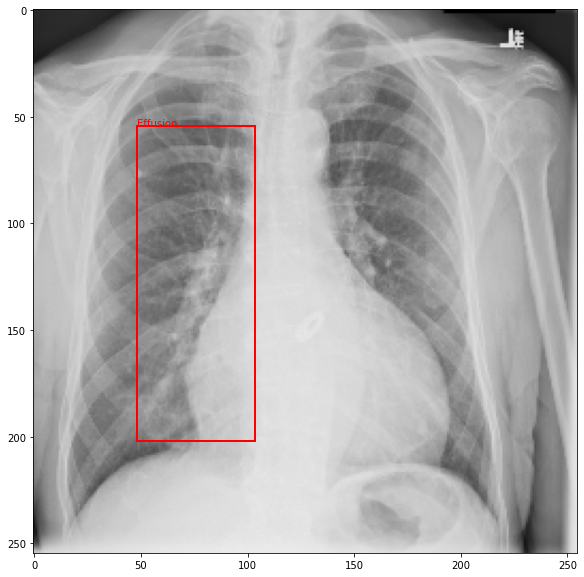

In [115]:
## Plot an image and overlay its bounding box on top of it
def plotImage(image, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    a.imshow(image)
    ## get the context for drawing boxes
    ax = plt.gca()
    ## Plot each box
    for i in range(len(target['boxes'])):
        box = target['boxes'][i]
        x, y, width, height  = box[0], box[1], box[2] - box[0], box[3] - box[1]
        ## Create rectangle patch for bounding box
        rect = patches.Rectangle((x, y), width, height, linewidth = 2, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
        ## Draw text on top of box
        label = "%s" % (classes[target['labels'][i]])
        plt.text(x, y, label, color='red')
    ## show the plot
    plt.show()
    
## Plot a sample image
image, target = dataset[175]
plotImage(image, target)

## Import ResNet-50-FPN model

In [116]:
## Create the base model to be trained
def detectionModel(numClasses):
    ## Load a model pretrained resnet model to speed training time
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    ## Get number of input features for the classifier
    inFeatures = model.roi_heads.box_predictor.cls_score.in_features
    ## Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(inFeatures, numClasses) 

    return model

## Data transformations during training to reduce overfit
def createTransform(train):
    if train:
        return A.Compose([A.HorizontalFlip(0.5), ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Split training and test data

In [117]:
## Initialize train and test objects
dataTrain = NIHData(428, 428, createTransform(True))
dataTest = NIHData(428, 428, createTransform(False))

## Split the dataset into train and test sets
torch.manual_seed(1)
indices = torch.randperm(len(dataTrain)).tolist()
dataSplit = 0.2
testSize = int(len(dataTrain)*dataSplit)
dataTrain = torch.utils.data.Subset(dataTrain, indices[:-testSize])
dataTest = torch.utils.data.Subset(dataTest, indices[-testSize:])

## Define training and validation data loaders
dataTrainLoader = torch.utils.data.DataLoader(dataTrain, batch_size=8, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
dataTestLoader = torch.utils.data.DataLoader(dataTest, batch_size=8, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

## Initialize model

In [133]:
## Determine if we can use a GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Initialize model
numClasses = 9
model = detectionModel(numClasses)
model.to(device)

## Construct an optimizer and learning rate
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.009, momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)
lrScheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## Train the model

In [134]:
## Choose number of training epochs
numEpochs = 25

## Tensorboard writer
# writer = SummaryWriter()
    
## Train one epoch at a time for numEpochs
for epoch in range(numEpochs):
    train_one_epoch(model, optimizer, dataTrainLoader, device, epoch, print_freq=10)
    ## Update the learning rate
    lrScheduler.step()
    ## Evaluate on the test dataset
    evaluate(model, dataTestLoader, device=device)

Epoch: [0]  [ 0/88]  eta: 0:02:45  lr: 0.000112  loss: 2.6917 (2.6917)  loss_classifier: 2.5182 (2.5182)  loss_box_reg: 0.0293 (0.0293)  loss_objectness: 0.1329 (0.1329)  loss_rpn_box_reg: 0.0113 (0.0113)  time: 1.8834  data: 0.7617  max mem: 11829
Epoch: [0]  [10/88]  eta: 0:01:18  lr: 0.001146  loss: 1.3832 (1.4443)  loss_classifier: 1.2368 (1.2719)  loss_box_reg: 0.0513 (0.0484)  loss_objectness: 0.0988 (0.1124)  loss_rpn_box_reg: 0.0102 (0.0115)  time: 1.0039  data: 0.0971  max mem: 11829
Epoch: [0]  [20/88]  eta: 0:01:05  lr: 0.002179  loss: 0.4022 (0.9431)  loss_classifier: 0.2197 (0.7727)  loss_box_reg: 0.0602 (0.0606)  loss_objectness: 0.0859 (0.0997)  loss_rpn_box_reg: 0.0089 (0.0100)  time: 0.9150  data: 0.0306  max mem: 11829
Epoch: [0]  [30/88]  eta: 0:00:54  lr: 0.003213  loss: 0.3009 (0.7247)  loss_classifier: 0.1505 (0.5662)  loss_box_reg: 0.0666 (0.0642)  loss_objectness: 0.0646 (0.0856)  loss_rpn_box_reg: 0.0066 (0.0087)  time: 0.9081  data: 0.0291  max mem: 11829
Epoc

Epoch: [2]  [10/88]  eta: 0:01:19  lr: 0.009000  loss: 0.2416 (0.2391)  loss_classifier: 0.1243 (0.1224)  loss_box_reg: 0.0788 (0.0774)  loss_objectness: 0.0361 (0.0328)  loss_rpn_box_reg: 0.0052 (0.0065)  time: 1.0231  data: 0.1169  max mem: 11829
Epoch: [2]  [20/88]  eta: 0:01:05  lr: 0.009000  loss: 0.2500 (0.2515)  loss_classifier: 0.1262 (0.1303)  loss_box_reg: 0.0805 (0.0810)  loss_objectness: 0.0333 (0.0337)  loss_rpn_box_reg: 0.0056 (0.0065)  time: 0.9109  data: 0.0265  max mem: 11829
Epoch: [2]  [30/88]  eta: 0:00:55  lr: 0.009000  loss: 0.2609 (0.2566)  loss_classifier: 0.1317 (0.1316)  loss_box_reg: 0.0818 (0.0810)  loss_objectness: 0.0421 (0.0372)  loss_rpn_box_reg: 0.0062 (0.0069)  time: 0.9073  data: 0.0285  max mem: 11829
Epoch: [2]  [40/88]  eta: 0:00:45  lr: 0.009000  loss: 0.2648 (0.2588)  loss_classifier: 0.1303 (0.1321)  loss_box_reg: 0.0818 (0.0820)  loss_objectness: 0.0404 (0.0369)  loss_rpn_box_reg: 0.0060 (0.0077)  time: 0.9096  data: 0.0283  max mem: 11829
Epoc

Epoch: [4]  [20/88]  eta: 0:01:05  lr: 0.000900  loss: 0.2619 (0.2646)  loss_classifier: 0.1372 (0.1390)  loss_box_reg: 0.0892 (0.0887)  loss_objectness: 0.0296 (0.0313)  loss_rpn_box_reg: 0.0057 (0.0056)  time: 0.9139  data: 0.0278  max mem: 11829
Epoch: [4]  [30/88]  eta: 0:00:54  lr: 0.000900  loss: 0.2592 (0.2652)  loss_classifier: 0.1372 (0.1388)  loss_box_reg: 0.0919 (0.0887)  loss_objectness: 0.0310 (0.0320)  loss_rpn_box_reg: 0.0058 (0.0056)  time: 0.9193  data: 0.0303  max mem: 11829
Epoch: [4]  [40/88]  eta: 0:00:44  lr: 0.000900  loss: 0.2638 (0.2617)  loss_classifier: 0.1328 (0.1369)  loss_box_reg: 0.0886 (0.0870)  loss_objectness: 0.0310 (0.0316)  loss_rpn_box_reg: 0.0052 (0.0061)  time: 0.9158  data: 0.0299  max mem: 11829
Epoch: [4]  [50/88]  eta: 0:00:35  lr: 0.000900  loss: 0.2716 (0.2675)  loss_classifier: 0.1334 (0.1392)  loss_box_reg: 0.0913 (0.0892)  loss_objectness: 0.0315 (0.0321)  loss_rpn_box_reg: 0.0054 (0.0071)  time: 0.9122  data: 0.0288  max mem: 11829
Epoc

Epoch: [6]  [30/88]  eta: 0:00:54  lr: 0.000090  loss: 0.2659 (0.2657)  loss_classifier: 0.1389 (0.1376)  loss_box_reg: 0.0877 (0.0889)  loss_objectness: 0.0281 (0.0319)  loss_rpn_box_reg: 0.0050 (0.0073)  time: 0.9105  data: 0.0288  max mem: 11829
Epoch: [6]  [40/88]  eta: 0:00:45  lr: 0.000090  loss: 0.2790 (0.2673)  loss_classifier: 0.1450 (0.1390)  loss_box_reg: 0.1017 (0.0897)  loss_objectness: 0.0281 (0.0314)  loss_rpn_box_reg: 0.0050 (0.0072)  time: 0.9166  data: 0.0303  max mem: 11829
Epoch: [6]  [50/88]  eta: 0:00:35  lr: 0.000090  loss: 0.2509 (0.2631)  loss_classifier: 0.1338 (0.1367)  loss_box_reg: 0.0884 (0.0889)  loss_objectness: 0.0266 (0.0305)  loss_rpn_box_reg: 0.0055 (0.0069)  time: 0.9146  data: 0.0300  max mem: 11829
Epoch: [6]  [60/88]  eta: 0:00:26  lr: 0.000090  loss: 0.2368 (0.2581)  loss_classifier: 0.1189 (0.1340)  loss_box_reg: 0.0810 (0.0871)  loss_objectness: 0.0256 (0.0301)  loss_rpn_box_reg: 0.0055 (0.0069)  time: 0.9098  data: 0.0286  max mem: 11829
Epoc

Epoch: [8]  [40/88]  eta: 0:00:44  lr: 0.000090  loss: 0.2550 (0.2573)  loss_classifier: 0.1343 (0.1335)  loss_box_reg: 0.0894 (0.0874)  loss_objectness: 0.0266 (0.0293)  loss_rpn_box_reg: 0.0058 (0.0071)  time: 0.9105  data: 0.0280  max mem: 11829
Epoch: [8]  [50/88]  eta: 0:00:35  lr: 0.000090  loss: 0.2500 (0.2579)  loss_classifier: 0.1295 (0.1337)  loss_box_reg: 0.0822 (0.0872)  loss_objectness: 0.0319 (0.0299)  loss_rpn_box_reg: 0.0058 (0.0071)  time: 0.9086  data: 0.0282  max mem: 11829
Epoch: [8]  [60/88]  eta: 0:00:25  lr: 0.000090  loss: 0.2573 (0.2592)  loss_classifier: 0.1344 (0.1350)  loss_box_reg: 0.0867 (0.0877)  loss_objectness: 0.0302 (0.0297)  loss_rpn_box_reg: 0.0057 (0.0068)  time: 0.9146  data: 0.0290  max mem: 11829
Epoch: [8]  [70/88]  eta: 0:00:16  lr: 0.000090  loss: 0.2642 (0.2620)  loss_classifier: 0.1413 (0.1368)  loss_box_reg: 0.0889 (0.0885)  loss_objectness: 0.0302 (0.0299)  loss_rpn_box_reg: 0.0053 (0.0068)  time: 0.9152  data: 0.0293  max mem: 11829
Epoc

Epoch: [10]  [50/88]  eta: 0:00:35  lr: 0.000009  loss: 0.2704 (0.2563)  loss_classifier: 0.1377 (0.1335)  loss_box_reg: 0.0912 (0.0854)  loss_objectness: 0.0290 (0.0304)  loss_rpn_box_reg: 0.0061 (0.0070)  time: 0.9131  data: 0.0281  max mem: 11829
Epoch: [10]  [60/88]  eta: 0:00:25  lr: 0.000009  loss: 0.2589 (0.2555)  loss_classifier: 0.1297 (0.1330)  loss_box_reg: 0.0922 (0.0860)  loss_objectness: 0.0255 (0.0298)  loss_rpn_box_reg: 0.0054 (0.0067)  time: 0.9109  data: 0.0287  max mem: 11829
Epoch: [10]  [70/88]  eta: 0:00:16  lr: 0.000009  loss: 0.2589 (0.2581)  loss_classifier: 0.1299 (0.1347)  loss_box_reg: 0.0922 (0.0869)  loss_objectness: 0.0293 (0.0298)  loss_rpn_box_reg: 0.0055 (0.0068)  time: 0.9155  data: 0.0294  max mem: 11829
Epoch: [10]  [80/88]  eta: 0:00:07  lr: 0.000009  loss: 0.2720 (0.2601)  loss_classifier: 0.1461 (0.1359)  loss_box_reg: 0.0926 (0.0881)  loss_objectness: 0.0270 (0.0295)  loss_rpn_box_reg: 0.0055 (0.0066)  time: 0.9139  data: 0.0283  max mem: 11829


Epoch: [12]  [60/88]  eta: 0:00:26  lr: 0.000001  loss: 0.2643 (0.2594)  loss_classifier: 0.1379 (0.1362)  loss_box_reg: 0.0887 (0.0873)  loss_objectness: 0.0302 (0.0293)  loss_rpn_box_reg: 0.0064 (0.0067)  time: 0.9119  data: 0.0285  max mem: 11829


KeyboardInterrupt: 

## Implement Non Max Suppresion

In [ ]:
# !pip install tensorboard --quiet
# !tensorboard --logdir=runs --host=127.0.0.1 --port 4200

In [135]:
## Non Max Suppression to determine best bounding box based on IOU threshold
def nms(prediction, thresh):
    ## Indeces of best bounding boxes
    bestBox = torchvision.ops.nms(prediction['boxes'], prediction['scores'], thresh)
    newPrediction = prediction
    newPrediction['boxes'] = newPrediction['boxes'][bestBox]
    newPrediction['scores'] = newPrediction['scores'][bestBox]
    newPrediction['labels'] = newPrediction['labels'][bestBox]
    
    return newPrediction

## Convert torch tensor to PIL image
def torchToPIL(image):
    return transforms.ToPILImage()(image).convert('RGB')

## Test model on test dataset

In [136]:
## Random image from test dataset
image, target = dataTest[57]
model.eval()
with torch.no_grad():
    prediction = model([image.to(device)])[0]
    
print('Predicted number of boxes: ', len(prediction['labels']))
print('True number of boxes: ', len(target['labels']))

Predicted number of boxes:  7
True number of boxes:  1


## Visualize predictions and ground truth

EXPECTED OUTPUT


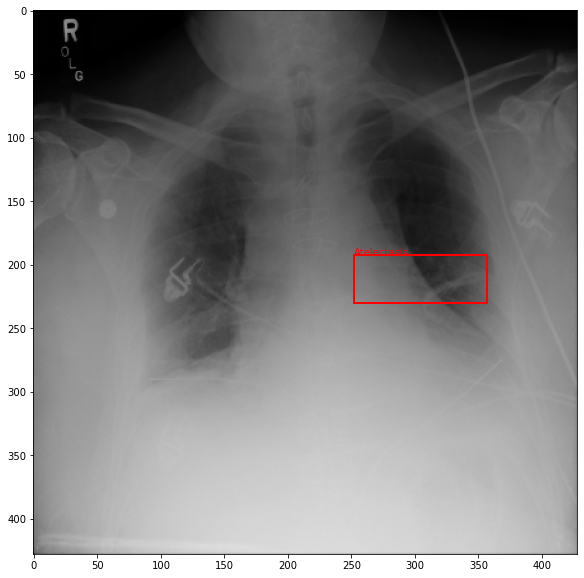

In [137]:
print('EXPECTED OUTPUT')
plotImage(torchToPIL(image), target)

RAW MODEL OUTPUT


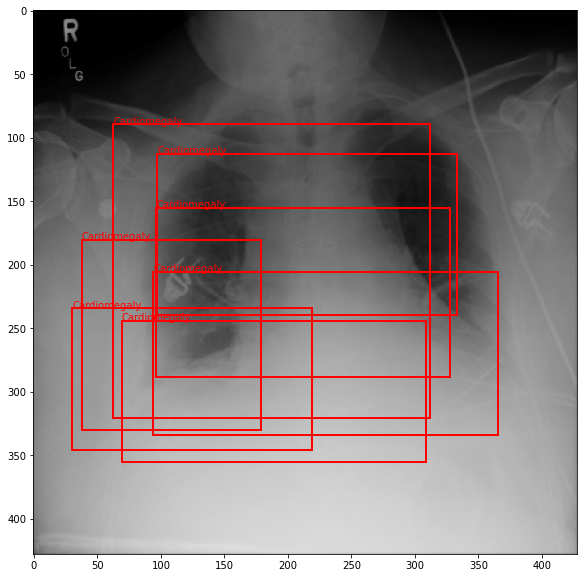

In [138]:
print('RAW MODEL OUTPUT')
plotImage(torchToPIL(image), prediction)

NMS APPLIED MODEL OUTPUT
IOU: 0.33432456851005554
IOU: 0.07285436242818832
IOU: 0.06839704513549805


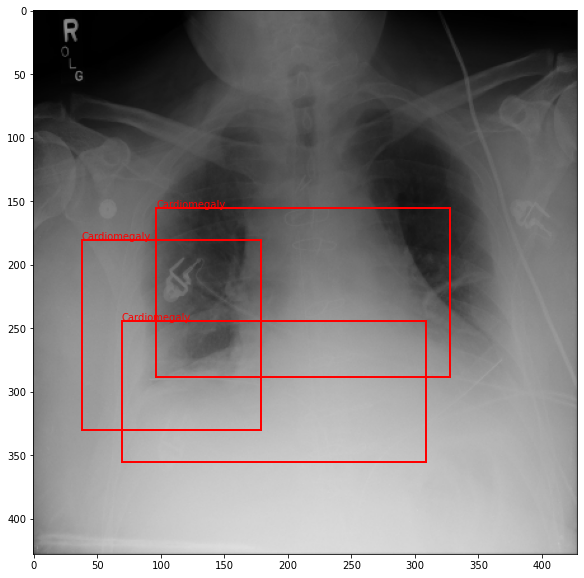

In [139]:
nmsPrediction = nms(prediction, 0.1)
print("NMS APPLIED MODEL OUTPUT")
for x in range(len(nmsPrediction['scores'])):
    print("IOU:", nmsPrediction['scores'][x].item())
plotImage(torchToPIL(image), nmsPrediction)